In [13]:
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
#from geopy import geocoders 
import scipy, json, csv, time
import numpy as np
import pandas as pd
%matplotlib notebook

In [14]:
df = pd.read_csv('baseline_def_kaggle.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,open,high,low,close,volume,market,close_ratio,spread,prevClose,7 Day Rolling Mean,7 Day SD,percentChange,isEvent based on 2SD,Naive Percent Event
0,763.28,777.51,713.60,735.07,46862700.0,8.955395e+09,0.3359,63.91,735.07,755.982857,24.982272,0.000000,0,False
1,737.98,747.06,705.35,727.83,32505800.0,8.869919e+09,0.5390,41.71,735.07,755.982857,24.982272,-0.009849,0,False
2,728.05,748.61,714.44,745.05,19011300.0,9.082104e+09,0.8958,34.17,727.83,755.982857,24.982272,0.023659,0,False
3,741.35,766.60,740.24,756.13,20707700.0,9.217168e+09,0.6028,26.36,745.05,755.982857,24.982272,0.014871,0,False
4,760.32,760.58,738.17,754.01,20897300.0,9.191325e+09,0.7068,22.41,756.13,755.982857,24.982272,-0.002804,0,False


In [15]:
data = df[['close', 'volume', 'market', 'spread', 'percentChange']]
#data = df[['close', 'percentChange', 'market']]
data.head()

,close,volume,market,spread,percentChange
0,735.07,46862700.0,8.955395e+09,63.91,0.000000
1,727.83,32505800.0,8.869919e+09,41.71,-0.009849
2,745.05,19011300.0,9.082104e+09,34.17,0.023659
3,756.13,20707700.0,9.217168e+09,26.36,0.014871
4,754.01,20897300.0,9.191325e+09,22.41,-0.002804


In [23]:
def baseline_colors(x):
    if x:
        return 'Firebrick'
    else:
        return 'ForestGreen'

colors_2sd = df['isEvent based on 2SD'].apply(baseline_colors).values
colors_percent = df['isEvent based on 2SD'].apply(baseline_colors).values

<IPython.core.display.Javascript object>


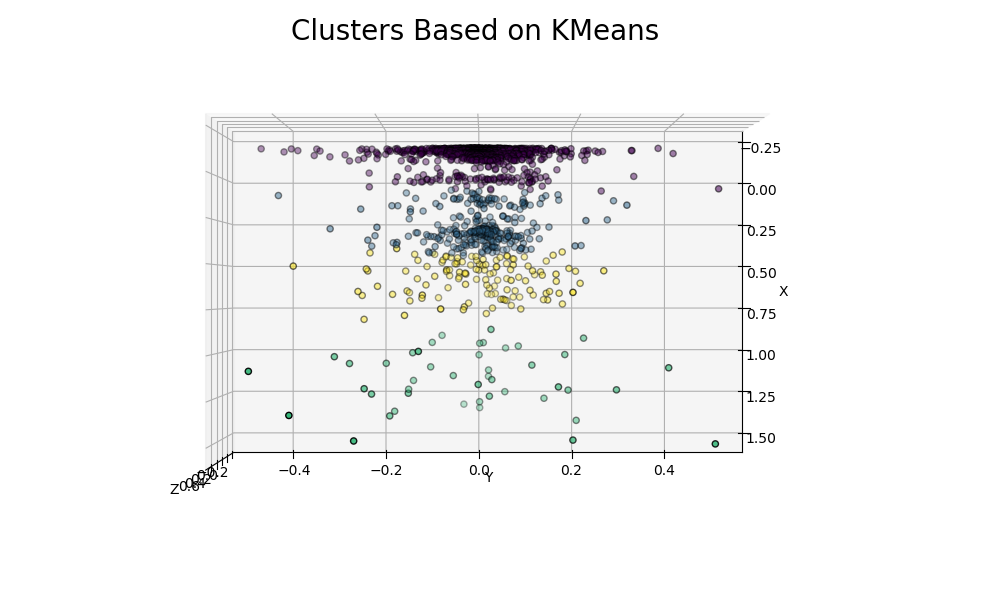

In [16]:
num_clusters = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in num_clusters]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(num_clusters, scores)
plt.xticks(num_clusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show();

From this we can see the best number of clusters to use is 4.

<IPython.core.display.Javascript object>


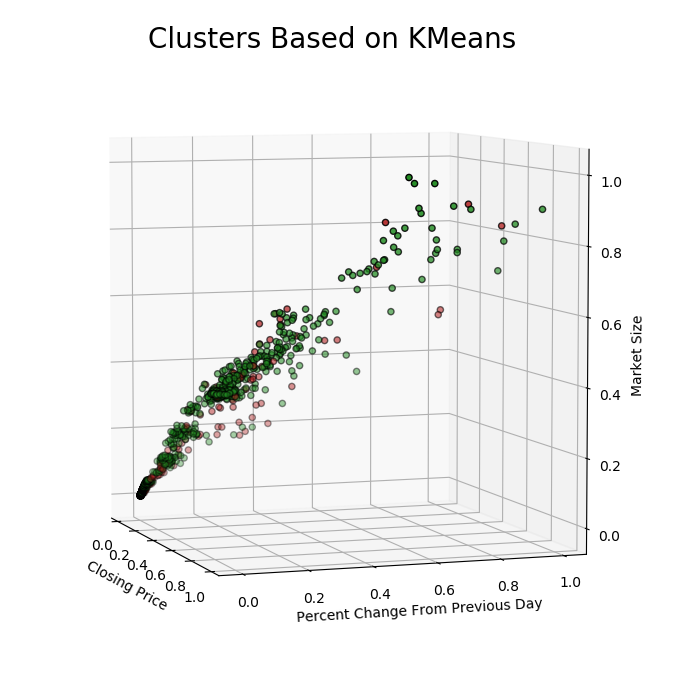

Text(0.5,0.92,'Clusters Based on KMeans')

In [26]:
%matplotlib notebook
#Choosing the best number of clusters based on the elbow curve
best_num_cluster = 4
data2 = df[['close', 'volume', 'market', 'spread', 'percentChange']]
data2 = data2.reset_index(drop=True)
km = KMeans(n_clusters=best_num_cluster)
km.fit(data)
km.predict(data)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=0)
#ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2],c=labels.astype(np.float), edgecolor="k")
ax.scatter(data.iloc[:,0], data.iloc[:,1], data.iloc[:,2],c=colors_2sd, edgecolor="k")
ax.set_xlabel("Closing Price")
ax.set_ylabel("Percent Change From Previous Day")
ax.set_zlabel("Market Size")
plt.title("Clusters Based on KMeans", fontsize=20)


In [43]:
%matplotlib notebook
from sklearn.decomposition import PCA
# Normalization
data[:] = MinMaxScaler().fit_transform(data[:])
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
correlations = pd.DataFrame(data=data).corr()
feature_names = ['close', 'volume', 'market', 'spread', 'percentChange']

pca = PCA(n_components=4)
pca.fit(data)
reduced_data = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._setit

<IPython.core.display.Javascript object>


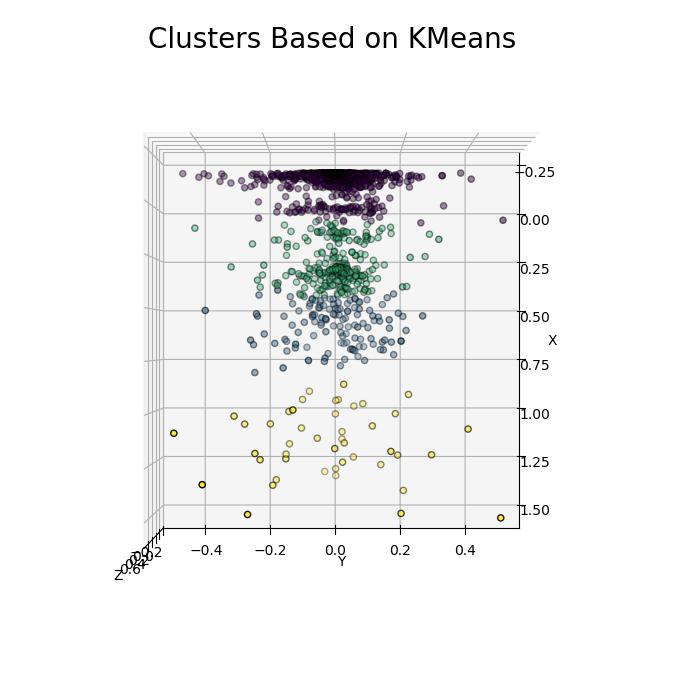

In [44]:
%matplotlib notebook
km = KMeans(n_clusters=best_num_cluster)
km.fit(reduced_data)
km.predict(reduced_data)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=90, azim=0)
ax.scatter(reduced_data.iloc[:,0], reduced_data.iloc[:,1], reduced_data.iloc[:,2],
         c=labels.astype(np.float), edgecolor="k")
           #c=colors_percent, edgecolor="k")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("Clusters Based on KMeans", fontsize=20)
plt.show()

In [7]:
def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (10,10))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [8]:
def vis_PCA3D(color, colormap, title):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection="3d")
    # scatterplot of the reduced data    
    ax.scatter(xs=reduced_data[0], ys=reduced_data[1], zs=reduced_data[2], s=5, alpha=0.5, c=color, cmap=colormap)

    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.plot([0,arrow_size*v[0]], [0,arrow_size*v[1]], zs=[0,arrow_size*v[2]])
        ax.text(v[0]*text_pos, v[1]*text_pos, v[2]*text_pos, df.columns[i], color="black", ha="center", va="center", fontsize=10)

    ax.set_title("PC plane with original feature projections.", fontsize=16);
    ax
    #plt.savefig("/vectors3DPer{0}.png".format(title), dpi = 300)

NOT 100% sure about feature_names

In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


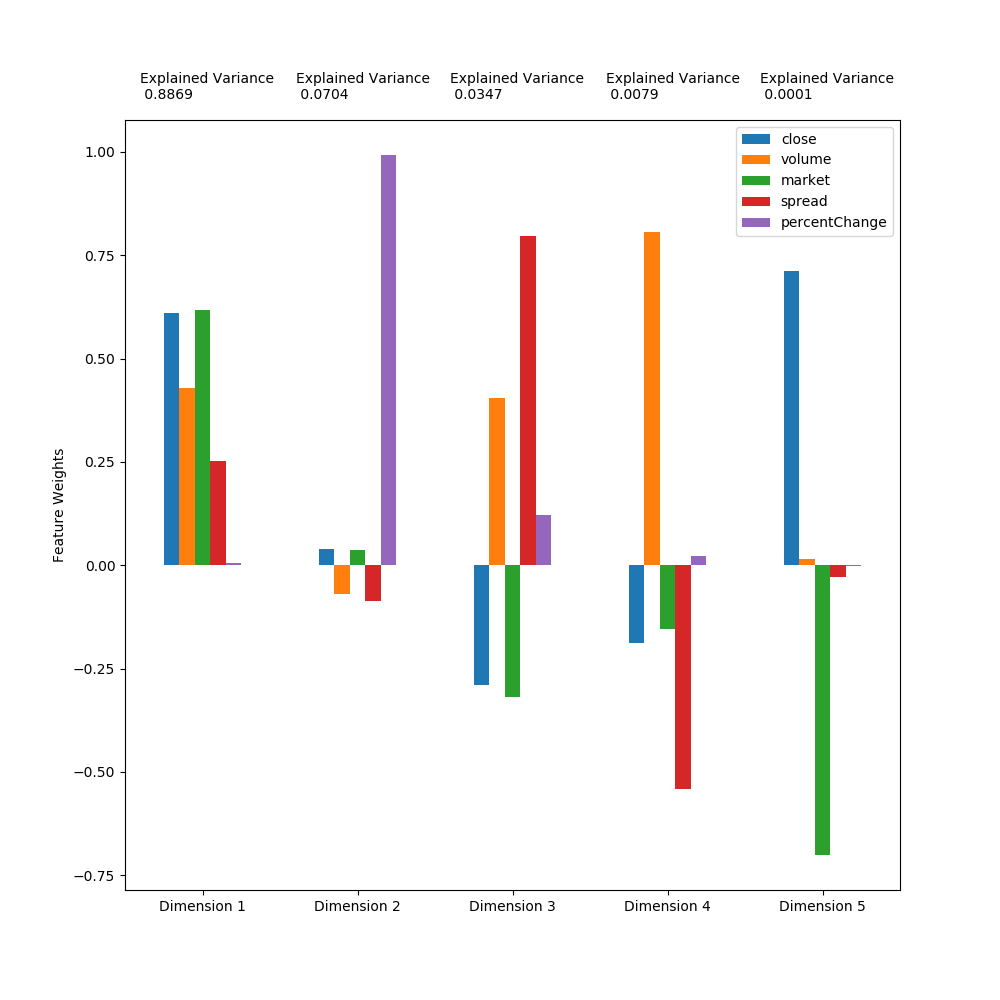

,Explained Variance,close,volume,market,spread,percentChange
Dimension 1,0.8869,0.6091,0.4287,0.6178,0.2522,0.0050
Dimension 2,0.0704,0.0386,-0.0697,0.0378,-0.0869,0.9923
Dimension 3,0.0347,-0.2907,0.4036,-0.3198,0.7972,0.1216
Dimension 4,0.0079,-0.1877,0.8052,-0.1531,-0.5409,0.0224
Dimension 5,0.0001,0.7126,0.0140,-0.7009,-0.0280,-0.0025


In [33]:
pca_results(correlations, pca)

<IPython.core.display.Javascript object>


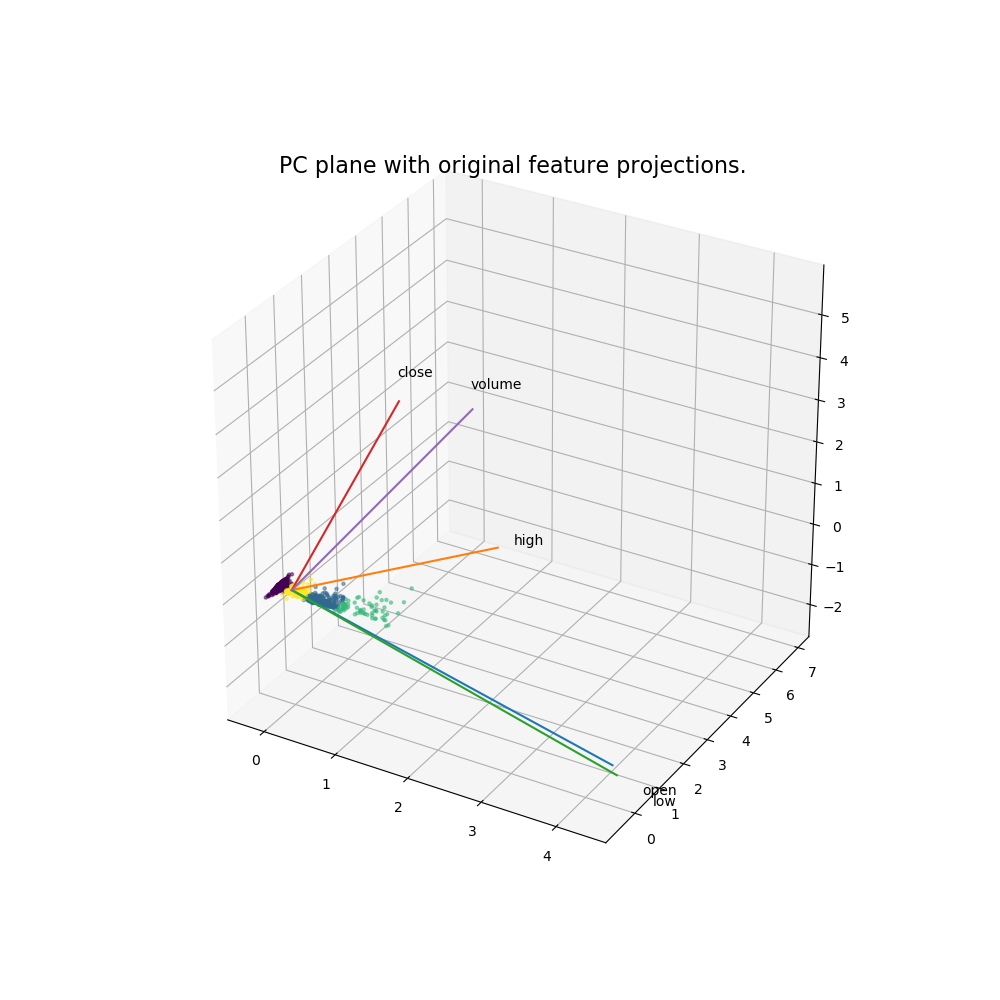

In [11]:
vis_PCA3D(color=labels.astype(np.float), colormap=None, title="3D PCA Visualization")